注意，此文件会在根目录外创建fig文件夹并产生图片

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号 
import matplotlib.cm as cm

import networkx as nx
import numpy as np

from matplotlib.patches import FancyArrowPatch
from PIL import Image
from itertools import product

np.random.seed(42)

# Hopfield网络的搭建

In [2]:
def mysign(x): #当x=0时，返回+1，作为神经元的激活函数
    return 2*np.heaviside(x,1)-1

class HopfieldNetwork(object):
    def __init__(self, pattern_size, iter=100):   #初始化，需要知道网络的大小吗，节点（神经元）的数目
        self.weights = np.zeros((pattern_size, pattern_size))
        self.thresholds = np.zeros(pattern_size)
        self.size=pattern_size
        self.iter=iter
    
    def train(self, train_data, zerodiag=True):    #使用Hebbian学习规则，即将需要学习的状态外积后作为权重矩阵
        print("Start to train weights...")
        train_data=np.array(train_data)
        num_data,self.num_neuron = train_data.shape
        
        for i in range(num_data):
            # t = train_data[i] - rho
            t = train_data[i]
            self.weights += np.outer(t, t)
        
        # Make diagonal element of W into 0
        if zerodiag:
            np.fill_diagonal(self.weights, 0)
        self.weights /= num_data
        print("Trian complete.")
    
    # def predict(self, input_pattern, max_iter=100):
    def predict(self, data, asyn=False):           #Hopfield网络开始行使功能，从有一定偏差的数据开始通过Hopfield网络动力学进行修复
        if len(data)!=self.size:                   #有两种动力学方法——同步更新方法和异步更新方法
            print ("Error, size not match.")
            return "Error, size not match."
        print("Start to predict...")
        num_iter = self.iter
        data=np.array(data)

        if (not asyn):
            """
            Synchronous update
            """
            # Compute initial state energy
            s = data.copy()
            # Iteration
            for i in range(num_iter):
                # Update s
                s_new = mysign(self.weights @ s - self.thresholds)
                if np.array_equal(s,s_new):
                    print("Predict Successfully!")
                    return s
                s = s_new.copy()
        else:
            """
            Asynchronous update
            """
            s = data.copy()
            for i in range(num_iter):
                s_new = s.copy()
                for j in range(self.size):
                    s_new[j] = mysign(self.weights[j] @ s_new - self.thresholds[j])
                if np.array_equal(s,s_new):
                    print("Predict Successfully!")
                    return s
                # Update energy
                s = s_new.copy()
        print("Maximum number of iterations reached. Pattern not stable.")
        return s
    
    def predict_detail(self, data, asyn=False):     #Hopfield网络动力学模拟，不同于上一个功能的地方在于，这个函数会记录从开始到稳定的全部迭代过程
        if len(data)!=self.size:
            print ("Error, size not match.")
            return "Error, size not match."
        print("Start to predict...")
        num_iter = self.iter
        data=np.array(data)

        if (not asyn):
            """
            Synchronous update
            """
            # Compute initial state energy
            s = data.copy()
            s_list=[s]
            # Iteration
            for i in range(num_iter):
                # Update s
                s = mysign(self.weights @ s - self.thresholds)
                if np.array_equal(s,s_list[-1]):
                    print("Predict Successfully!")
                    return s_list
                s_list.append(s)
        else:
            """
            Asynchronous update
            """
            # Compute initial state energy
            s = data.copy()
            s_list=[s]
            for i in range(num_iter):
                for j in range(self.size):
                    s[j] = mysign(self.weights[j] @ s - self.thresholds[j])
                if np.array_equal(s,s_list[-1]):
                    print("Predict Successfully!")
                    return s_list
                # Update energy
                s_list.append(s)
        print("Maximum number of iterations reached. Pattern not stable.")
        return s_list
    
    def predict_onestep(self,s,asyn=False):          #Hopfield网络动力学模拟，这个函数只会往后迭代一步
        s=np.array(s)
        if len(s)!=self.size:
            print ("Error, size not match.")
            return "Error, size not match."
        if asyn:
            for j in range(self.size):
                s[j] = mysign(self.weights[j] @ s - self.thresholds[j])
        else:
            s = mysign(self.weights @ s - self.thresholds)
        return s
    
    def plot_weights(self,net=False,save=''):       #展示网络权重，有两种方法，分别是plt.imshow和Network带权网络方法
        if net:                                     #带权网络方法在网络较大时渲染非常慢而且展示效果不好，将其设为可选方法
            plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
            plt.subplot(1, 2, 1)
        w_mat = plt.imshow(self.weights, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        if net:
            plt.subplot(1, 2, 2)
            G = nx.Graph()
            # 添加节点
            size=self.size
            weights=self.weights
            for i in range(size):
                for j in range(i + 1, size):
                    if weights[i, j] != 0:  # 只添加非零权重的边
                        G.add_edge(i, j, weight=weights[i, j])

            # 计算节点在正多边形上的坐标
            pos = {}
            for i in range(size):
                angle = 2 * np.pi * i / size
                x = np.cos(angle)
                y = np.sin(angle)
                pos[i] = (x, y)

            edge_colors = [weight for u, v, weight in G.edges.data('weight')]
            nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=10, font_color='black', font_family='sans-serif', edge_color=edge_colors, edge_cmap=plt.cm.coolwarm, width=3)

            # 添加颜色条
            sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm)
            sm.set_array([-1,1])
            cbar = plt.colorbar(sm, orientation='vertical')
            plt.title("Networks")
        if save:
            plt.tight_layout()
            plt.savefig(save, bbox_inches='tight')
        plt.show()

    def Phase_diagram(self,asyn=False,show=False,energy=False,save=''):    #绘制相图，由于是有限状态动力学，这和状态机等价
        G = nx.DiGraph()
        # print(self.size)
        pos={}
        for i in product("01", repeat=self.size):
            # print(i)
            i=np.array(i)
            i=np.where(i=='0',-1,1)
            # print(i)
            pos[np.array_str(i)]=tuple(i)
            i_next=self.predict_onestep(i,asyn).astype(int)
            G.add_edge(np.array_str(i), np.array_str(i_next))
        if show:
            # pos = nx.spring_layout(G, k=10)
            ax = plt.gca()
            if self.size==2:
                arrow = FancyArrowPatch(posA=(-1.5, 0), posB=(1.5, 0), arrowstyle='->', mutation_scale=15, color='red')
                ax.add_patch(arrow)
                arrow = FancyArrowPatch(posA=(0, -1.5), posB=(0, 1.5), arrowstyle='->', mutation_scale=15, color='blue')
                ax.add_patch(arrow)
            elif self.size==3:
                # print('ddd23')
                arrow = FancyArrowPatch(posA=(-2, 0), posB=(2, 0), arrowstyle='->', mutation_scale=15, color='red')
                ax.add_patch(arrow)
                arrow = FancyArrowPatch(posA=(0, -2), posB=(0, 2), arrowstyle='->', mutation_scale=15, color='blue')
                ax.add_patch(arrow)
                arrow = FancyArrowPatch(posA=(-0.25, -0.25), posB=(0.25, 0.25), arrowstyle='->', mutation_scale=15, color='green')
                ax.add_patch(arrow)
                for k in pos:
                    x,y,z=pos[k]
                    x+=z/2
                    y+=z/2
                    pos[k]=(x,y)
            else:
                pos = nx.circular_layout(G)
            edgelist=[]
            fixed_node=[]
            other_node=list(G.nodes())
            for i in G.edges():         # 分开绘制点和边，NetworkX的自指圈渲染效果不好，故将带自指圈（稳定状态，不动点）渲染为红色
                if i[0]==i[1]:
                    fixed_node.append(i[0])
                    other_node.remove(i[0])
                else:
                    edgelist.append(i)
            nx.draw_networkx_nodes(G, pos, nodelist=other_node, node_size=1500, node_color='blue',alpha=0.7)
            nx.draw_networkx_nodes(G, pos, nodelist=fixed_node, node_size=1500, node_color='red',alpha=0.7)
            if energy:
                node_labels = {node: f"{node}\n E={self.energy(np.fromstring(node[1:-1], sep=' ', dtype=int))}" for node in G.nodes}
                # node_labels = {node: f"{node}\n{np.array(eval(node))}" for node in G.nodes}
                # print(node_labels)
                nx.draw_networkx_labels(G, pos,labels=node_labels)
            else:
                nx.draw_networkx_labels(G, pos)
            # nx.draw_networkx_edges(G, pos,edgelist=edgelist, edge_color='gray', width=3.0)
            nx.draw_networkx_edges(G, pos,edgelist=edgelist, connectionstyle='arc3,rad=0.1', edge_color='gray', width=3.0, arrowsize=30)
            # nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, font_size=10, font_color='black', font_weight='bold', edge_color='gray', width=3.0, arrowsize=30,arrowstyle="<|-", connectionstyle='arc3,rad=0.1')
            if save:
                plt.tight_layout()
                plt.savefig(save, bbox_inches='tight')
            if asyn:
                plt.title('异步更新策略')
            else:
                plt.title('同步更新策略')
            plt.show()
        return G

    def energy(self, s):               # Hopfield网络的能量函数
        s=np.array(s,dtype=float)
        # print('s')
        return -0.5 * s @ self.weights @ s + s @ self.thresholds

# 小规模Hopfield Network的动力学分析

## 二元Hopfeild Network网络

Hopfeild网络记住$[-1,1]$

In [3]:
size=2
traindata=[-1,1]
# print(traindata)
hop_2=HopfieldNetwork(size)
hop_2.train([traindata,])

Start to train weights...
Trian complete.


[[ 0. -1.]
 [-1.  0.]]


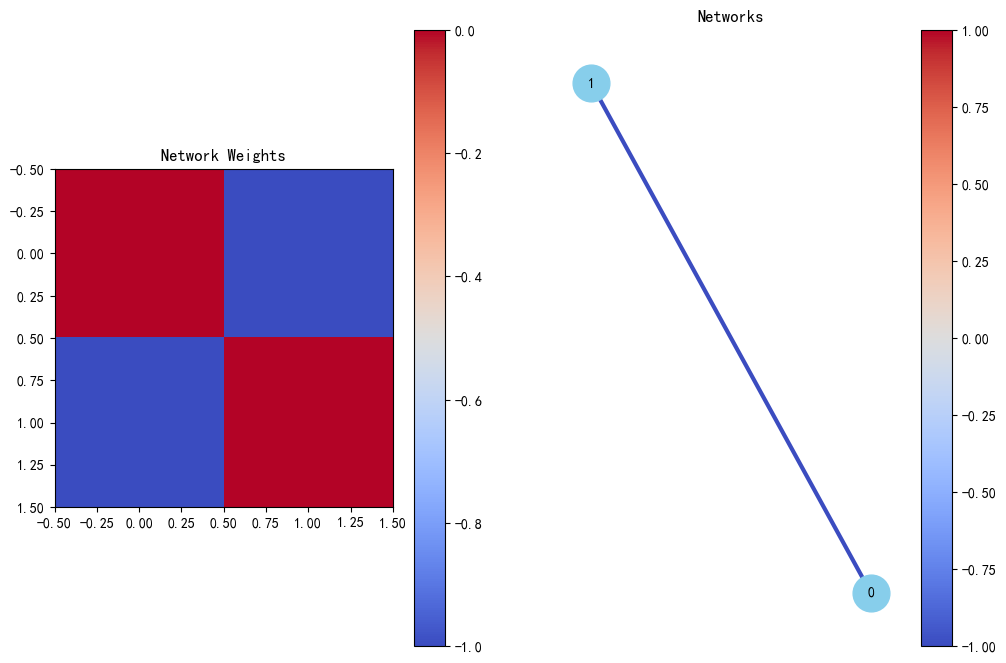

In [4]:
print(hop_2.weights)
hop_2.plot_weights(net=True)

In [5]:
array=[1,1]
print(f'同步更新策略：输入损坏的序列{array}')
trajectory_syn=hop_2.predict_detail(array)
print(trajectory_syn)

同步更新策略：输入损坏的序列[1, 1]
Start to predict...
Maximum number of iterations reached. Pattern not stable.
[array([1, 1]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), array([1., 1.]), array([-1., -1.]), ar

同步更新策略的相图


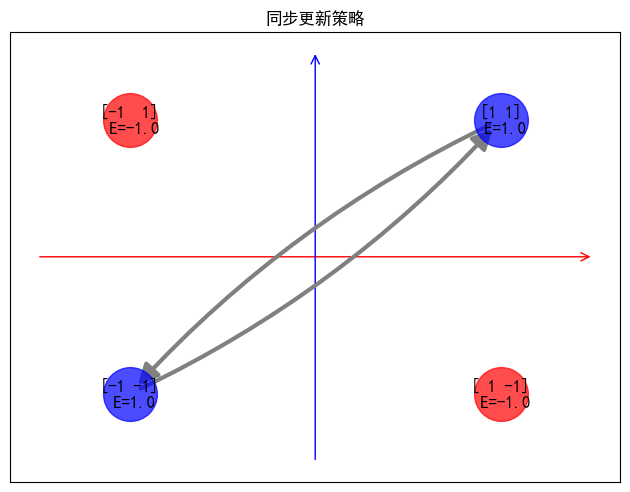

In [6]:
print(f'同步更新策略的相图')
hop_2.Phase_diagram(show=True,energy=True,save='../fig/2unitnet_syn+-.pdf')

In [7]:
array=[1,1]
print(f'异步更新策略：输入损坏的序列{array}')
trajectory_asyn=hop_2.predict_detail(array,asyn=True)
print(trajectory_asyn)

异步更新策略：输入损坏的序列[1, 1]
Start to predict...
Predict Successfully!
[array([-1,  1])]


异步更新策略的相图


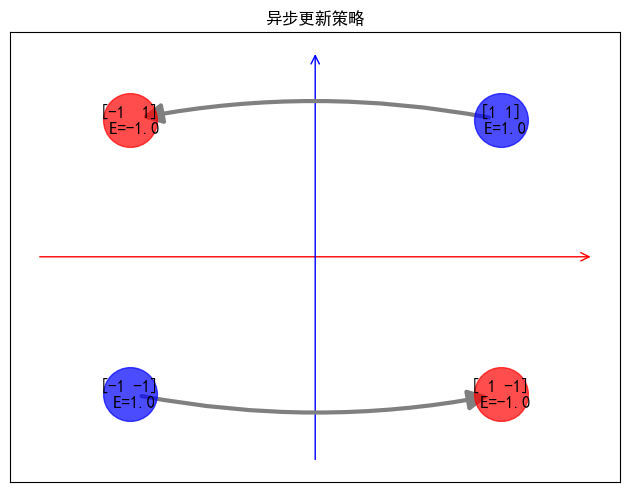

In [8]:
print(f'异步更新策略的相图')
hop_2.Phase_diagram(asyn=True,show=True,energy=True,save='../fig/2unitnet_asyn+-.pdf')

让Hopfield网络记住另一个序列$[-1,-1]$

In [9]:
size=2
traindata=[-1,-1]
# print(traindata)
hop_2=HopfieldNetwork(size)
hop_2.train([traindata,])
hop_2.weights


Start to train weights...
Trian complete.


array([[0., 1.],
       [1., 0.]])

同步更新策略的相图


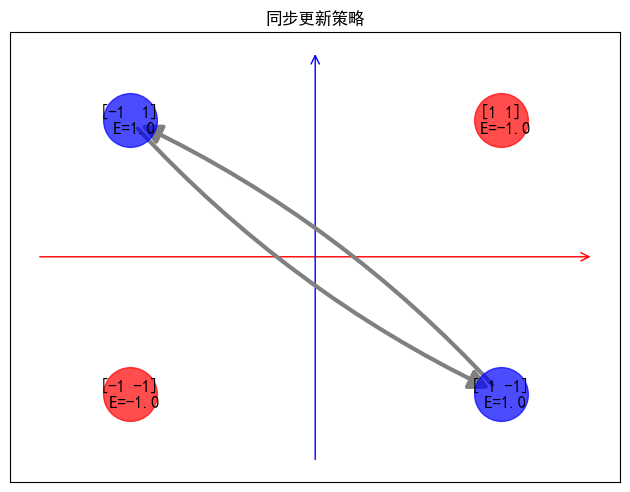

In [10]:
print(f'同步更新策略的相图')
hop_2.Phase_diagram(show=True,energy=True,save='../fig/2unitnet_syn++.pdf')

异步更新策略的相图


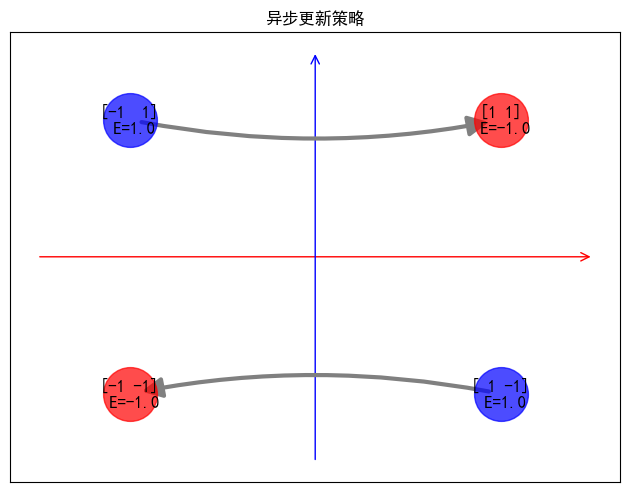

In [11]:
print(f'异步更新策略的相图')
hop_2.Phase_diagram(asyn=True,show=True,energy=True,save='../fig/2unitnet_asyn++.pdf')

## 三元Hopfeild网络

Start to train weights...
Trian complete.
[[ 0. -1. -1.]
 [-1.  0.  1.]
 [-1.  1.  0.]]


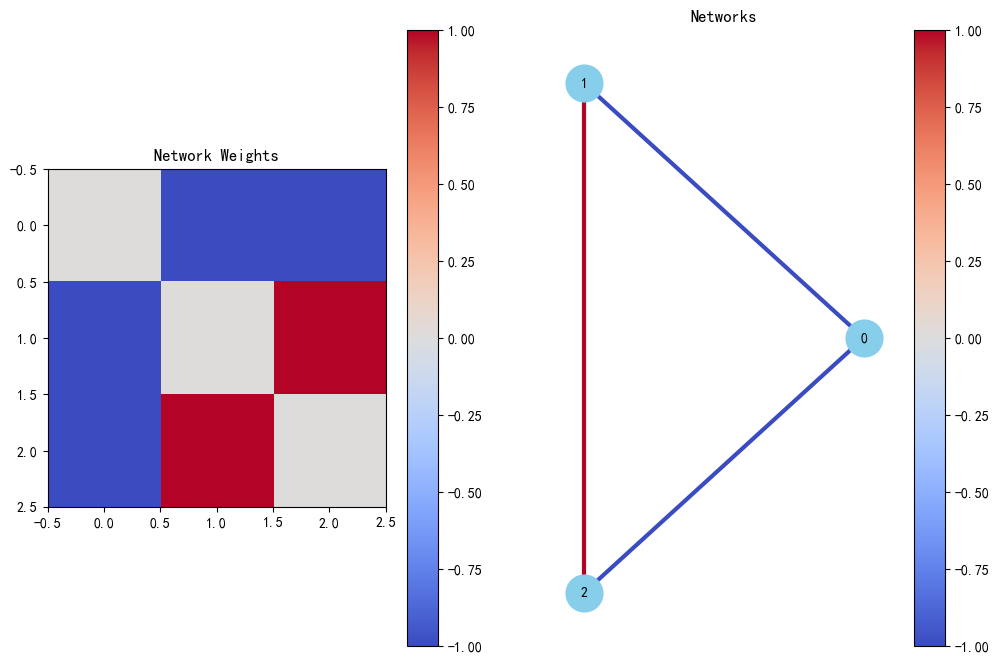

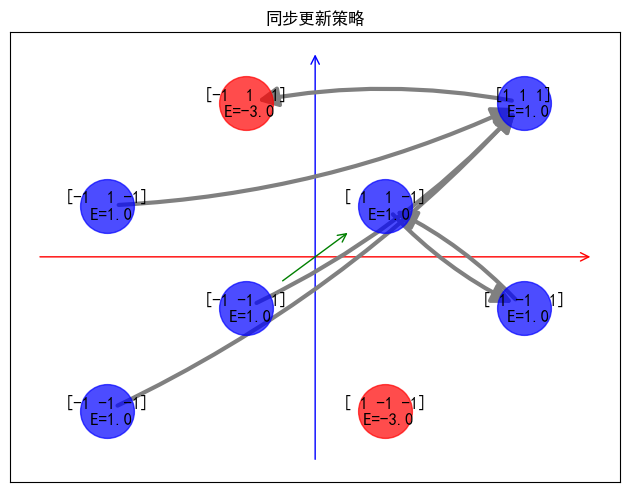

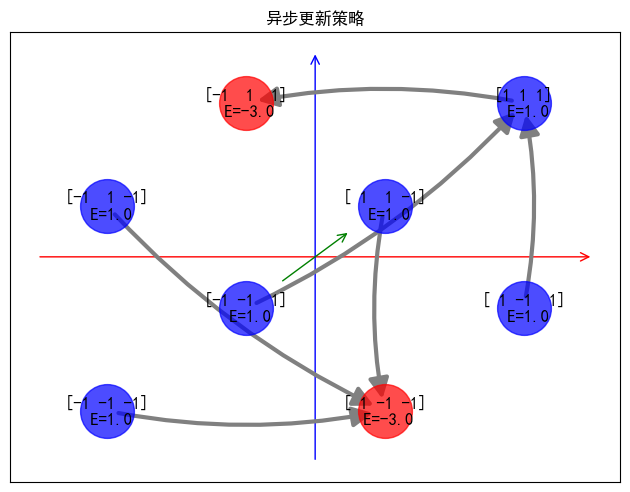

In [12]:
size=3
traindata=[-1,1,1]
# print(traindata)
hop_3=HopfieldNetwork(size)
hop_3.train([traindata,])
print(hop_3.weights)

# hop_3.predict_detail([-1,-1,1])
hop_3.plot_weights(net=True)
hop_3.Phase_diagram(show=True,energy=True,save='../fig/3unitnet_syn1.pdf')
hop_3.Phase_diagram(asyn=True,energy=True,show=True,save='../fig/3unitnet_asyn1.pdf')

Start to train weights...
Trian complete.
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


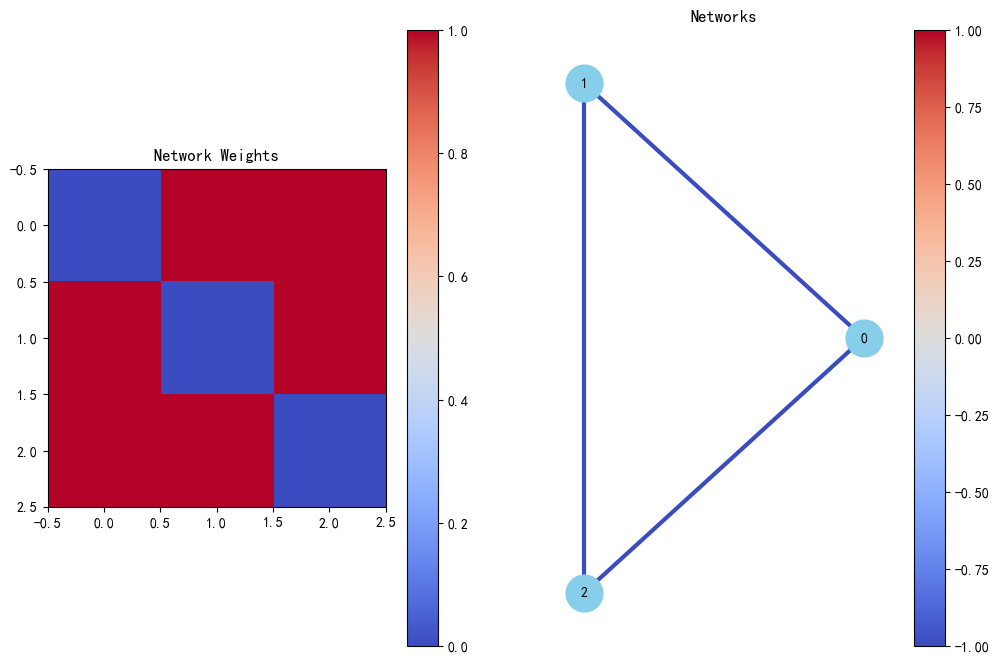

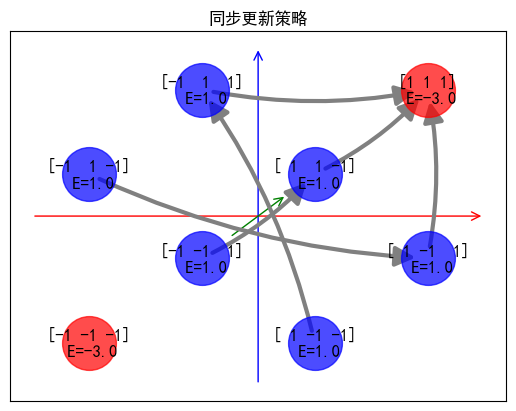

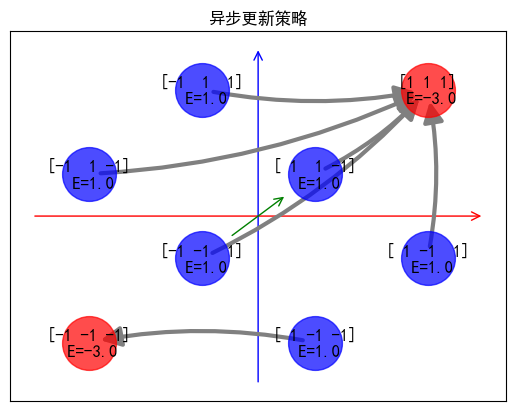

In [13]:
size=3
traindata=[1,1,1]
# print(traindata)
hop_3=HopfieldNetwork(size)
hop_3.train([traindata,])
print(hop_3.weights)

# hop_3.predict_detail([-1,-1,1])
hop_3.plot_weights(net=True)
hop_3.Phase_diagram(show=True,energy=True)#,save='../fig/3unitnet_syn2.pdf')
hop_3.Phase_diagram(asyn=True,energy=True,show=True)#,save='../fig/3unitnet_asyn2.pdf')

Start to train weights...
Trian complete.
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]


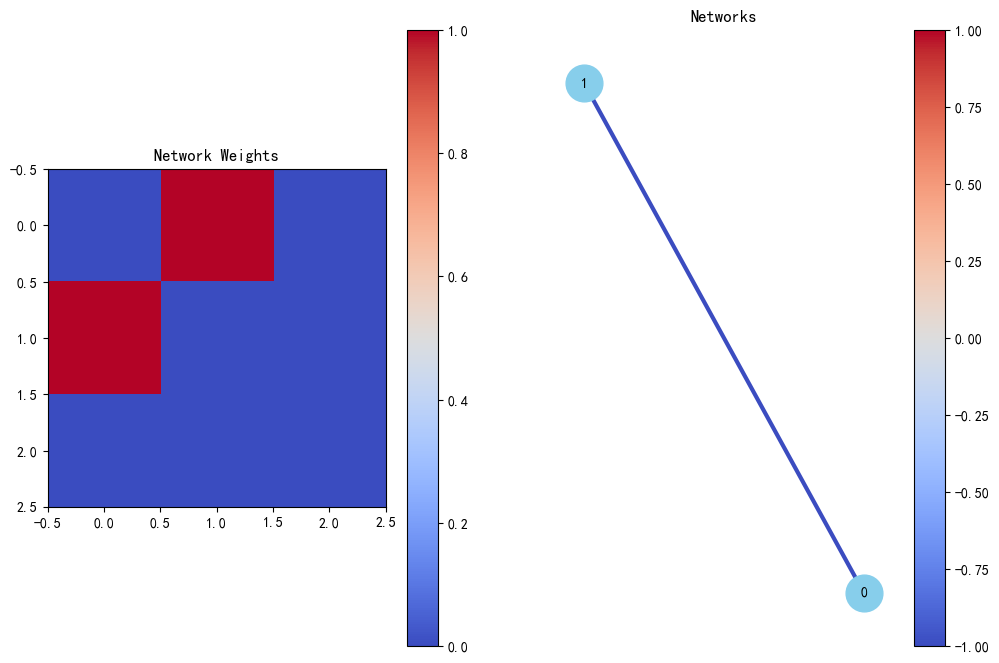

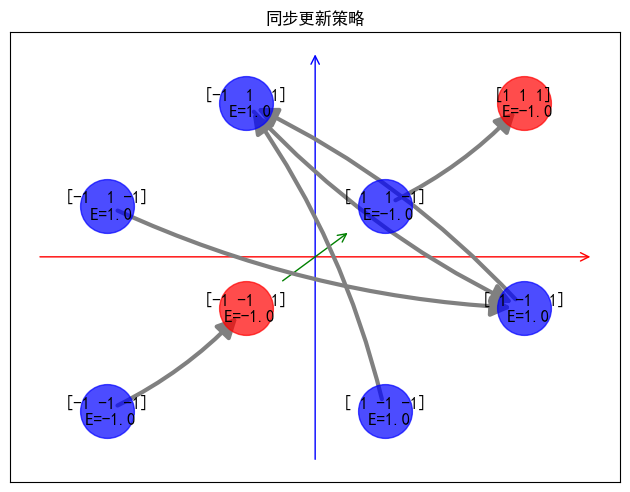

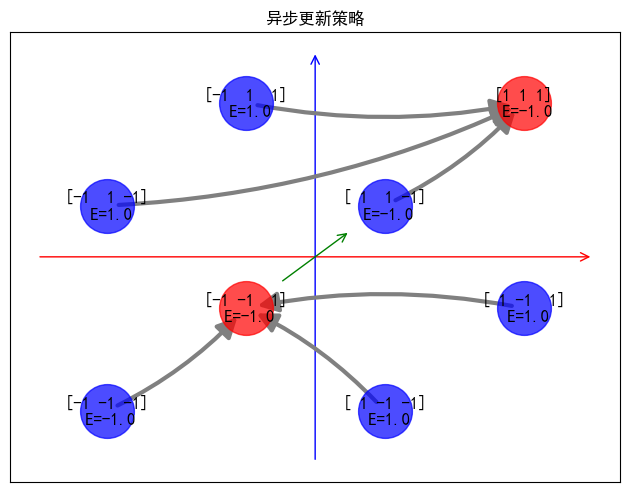

In [14]:
size=3
traindatas=[[1,1,1],[1,1,-1]]
# print(traindata)
hop_3=HopfieldNetwork(size)
hop_3.train(traindatas)
print(hop_3.weights)

# hop_3.predict_detail([-1,-1,1])
hop_3.plot_weights(net=True)
hop_3.Phase_diagram(show=True,energy=True,save='../fig/3unitnet_syn2.pdf')
hop_3.Phase_diagram(asyn=True,energy=True,show=True,save='../fig/3unitnet_asyn2.pdf')

In [15]:
size=4
traindata = np.random.choice([-1, 1], size=size)
print(traindata)

a=HopfieldNetwork(size)
print(a.size)
# data=
a.train([traindata,])

# a.predict([1,-1,1])
pridectdata=np.random.choice([-1, 1], size=size)
b=a.predict(pridectdata)
c=a.predict(pridectdata,asyn=True)

print("stroged data:",traindata)
print("broken data:",pridectdata)
print("AYN",b)
print("NAYN",c)

[-1  1 -1 -1]
4
Start to train weights...
Trian complete.
Start to predict...
Predict Successfully!
Start to predict...
Predict Successfully!
stroged data: [-1  1 -1 -1]
broken data: [-1  1 -1 -1]
AYN [-1  1 -1 -1]
NAYN [-1  1 -1 -1]


[[ 0. -1.  1.  1.]
 [-1.  0. -1. -1.]
 [ 1. -1.  0.  1.]
 [ 1. -1.  1.  0.]]


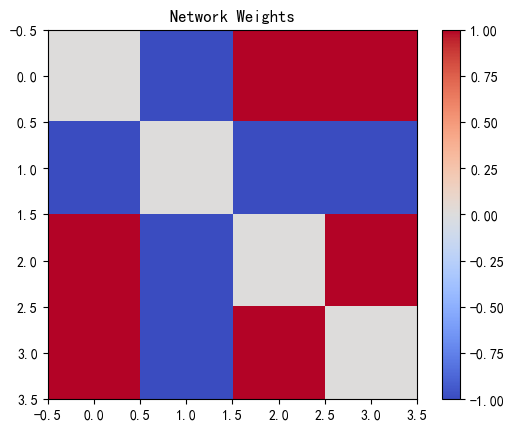

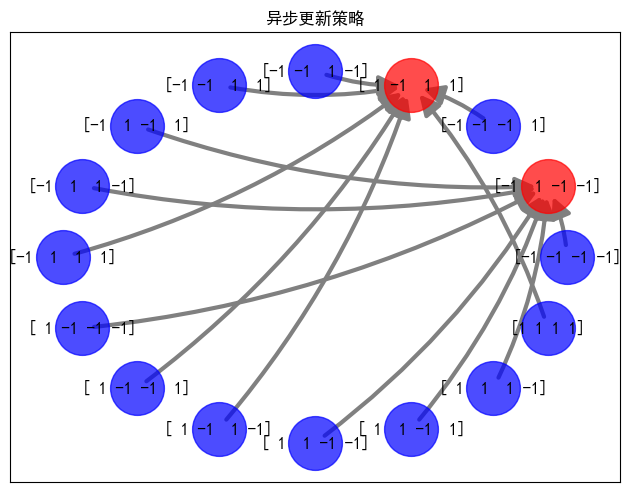

In [16]:
print(a.weights)
a.plot_weights()
a.Phase_diagram(asyn=True,show=True,save='../fig/4U.pdf')

In [17]:
size=10
traindata = np.random.choice([-1, 1], size=size)
print(traindata)
a=HopfieldNetwork(size)
print(a.size)
# data=
a.train([traindata,])
# a.predict([1,-1,1])
pridectdata=np.random.choice([-1, 1], size=size)
b=a.predict(pridectdata)
c=a.predict(pridectdata,asyn=True)

print("stroged data:",traindata)
print("broken data:",pridectdata)
print("AYN",b)
print("NAYN",c)

[-1  1 -1 -1 -1 -1  1 -1  1  1]
10
Start to train weights...
Trian complete.
Start to predict...
Predict Successfully!
Start to predict...
Predict Successfully!
stroged data: [-1  1 -1 -1 -1 -1  1 -1  1  1]
broken data: [ 1 -1  1 -1  1  1  1  1  1  1]
AYN [ 1. -1.  1.  1.  1.  1. -1.  1. -1. -1.]
NAYN [ 1 -1  1  1  1  1 -1  1 -1 -1]


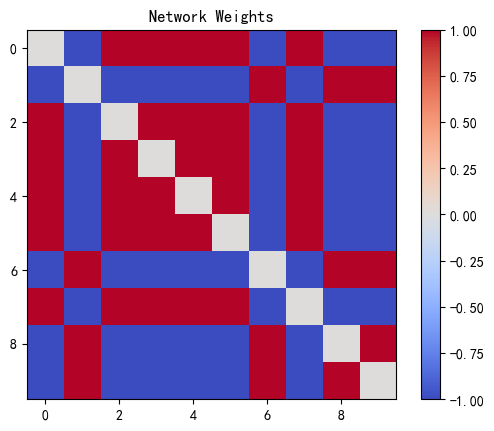

In [18]:
a.plot_weights()

# 实际的图片修复

## 单张图存储

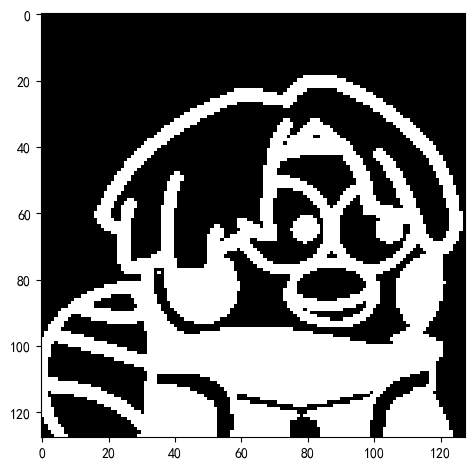

16384


In [19]:
im = Image.open('1.jpg')
im=im.convert('L')
im=im.resize((640,640))
# print(im)
pic_size = 128, 128
# im.thumbnail(size, Image.ANTIALIAS)
im.thumbnail(pic_size, Image.Resampling.LANCZOS)
im_np = np.asarray(im)
# print(im_np)
im_np = np.where(im_np<128, 1, -1)
# print(im_np)
plt.imshow(im_np, cmap='gray')
plt.tight_layout()
plt.savefig('../fig/picture1.pdf', bbox_inches='tight')
plt.show()
# print(im_np.shape)
im_np_line=im_np.reshape(-1)
size=im_np_line.shape[0]
print(size)

Start to train weights...
Trian complete.


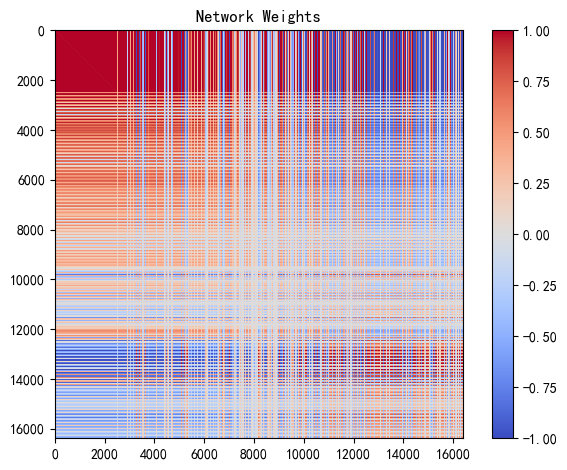

In [20]:
a=HopfieldNetwork(size)
a.train([im_np_line,])
a.plot_weights(save='../fig/weights1.pdf')

### 随机损坏

Start to predict...
Predict Successfully!


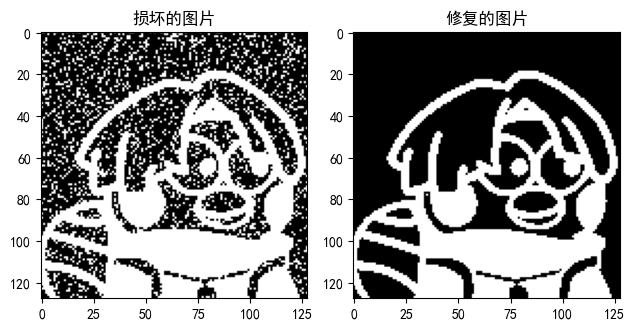

In [21]:
p=0.2
i_,j_=pic_size
destory_imnp=im_np.copy()
for i in range(i_):
    for j in range(j_):
        # print(i,j)
        # print(des_im_np[i][j])
        # print()
        if (np.random.uniform(0,1)<p):
            destory_imnp[i][j]=1
plt.subplot(1, 2, 1)
plt.imshow(destory_imnp, cmap='gray')
plt.title('损坏的图片')
destory_im_line = destory_imnp.reshape(-1)

pre_line=a.predict(destory_im_line)
pre_im=pre_line.reshape(pic_size)
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 2, 2)
plt.imshow(pre_im, cmap='gray')
plt.title('修复的图片')
plt.tight_layout()
plt.savefig('../fig/repicture1.pdf', bbox_inches='tight')
plt.show()

## 区域覆盖

Start to predict...


Predict Successfully!


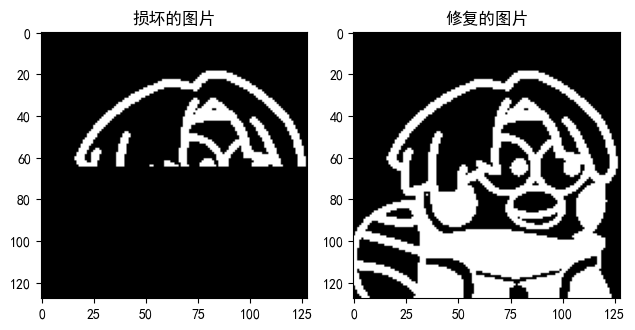

In [22]:
i_,j_=pic_size
destory_imnp=im_np.copy()
for i in range(i_):
    for j in range(j_):
        if (i>i_/2):
            destory_imnp[i][j]=-1
plt.subplot(1, 2, 1)
plt.imshow(destory_imnp, cmap='gray')
plt.title('损坏的图片')
destory_im_line = destory_imnp.reshape(-1)

pre_line=a.predict(destory_im_line)
pre_im=pre_line.reshape(pic_size)
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 2, 2)
plt.imshow(pre_im, cmap='gray')
plt.title('修复的图片')
plt.tight_layout()
plt.savefig('../fig/repicture2.pdf', bbox_inches='tight')
plt.show()

Start to predict...
Predict Successfully!


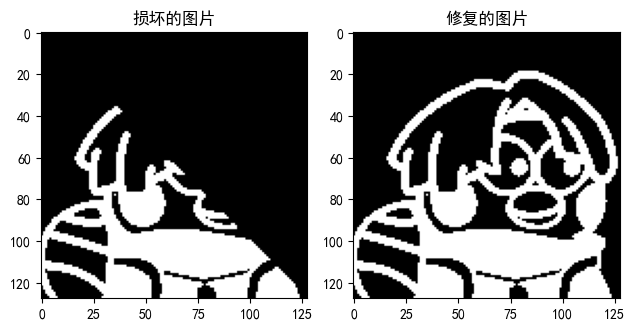

In [23]:
i_,j_=pic_size
destory_imnp=im_np.copy()
for i in range(i_):
    for j in range(j_):
        if (i<j):
            destory_imnp[i][j]=-1
plt.subplot(1, 2, 1)
plt.imshow(destory_imnp, cmap='gray')
plt.title('损坏的图片')
destory_im_line = destory_imnp.reshape(-1)

pre_line=a.predict(destory_im_line)
pre_im=pre_line.reshape(pic_size)
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 2, 2)
plt.imshow(pre_im, cmap='gray')
plt.title('修复的图片')
plt.tight_layout()
plt.savefig('../fig/repicture3.pdf', bbox_inches='tight')
plt.show()

Start to predict...
Predict Successfully!


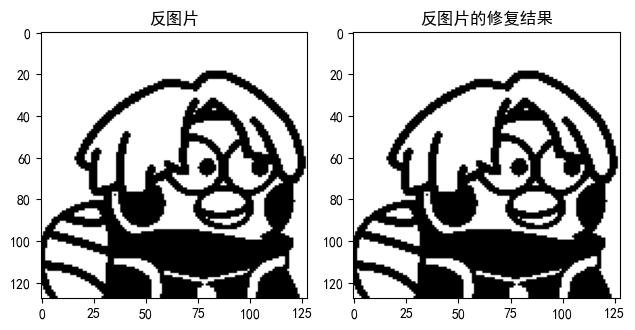

In [24]:
i_,j_=pic_size
destory_imnp=im_np.copy()
for i in range(i_):
    for j in range(j_):
        # if (i<j):
        destory_imnp[i][j]*=-1
plt.subplot(1, 2, 1)
plt.imshow(destory_imnp, cmap='gray')
plt.title('反图片')
destory_im_line = destory_imnp.reshape(-1)

pre_line=a.predict(destory_im_line)
pre_im=pre_line.reshape(pic_size)
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 2, 2)
plt.imshow(pre_im, cmap='gray')
plt.title('反图片的修复结果')
plt.tight_layout()
plt.savefig('../fig/repicture_anti1.pdf', bbox_inches='tight')
plt.show()

Start to predict...
Predict Successfully!


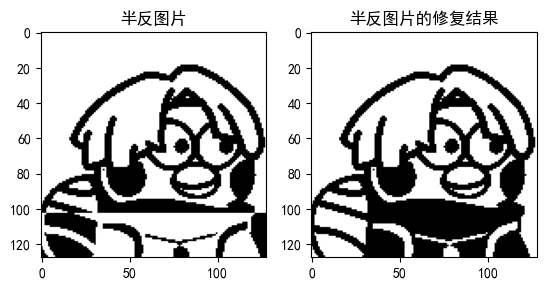

In [25]:
i_,j_=pic_size
destory_imnp=im_np.copy()
for i in range(i_):
    for j in range(j_):
        if (i<i_*0.8):
            destory_imnp[i][j]*=-1
plt.subplot(1, 2, 1)
plt.imshow(destory_imnp, cmap='gray')
plt.title('半反图片')
destory_im_line = destory_imnp.reshape(-1)

pre_line=a.predict(destory_im_line)
pre_im=pre_line.reshape(pic_size)
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 2, 2)
plt.imshow(pre_im, cmap='gray')
plt.title('半反图片的修复结果')
plt.show()

Start to predict...
Maximum number of iterations reached. Pattern not stable.


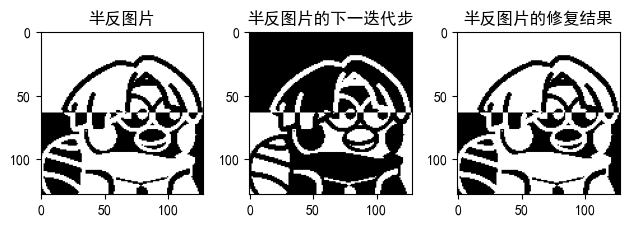

In [26]:
i_,j_=pic_size
destory_imnp=im_np.copy()
for i in range(i_):
    for j in range(j_):
        if (i<i_*0.5):
            destory_imnp[i][j]*=-1
plt.subplot(1, 3, 1)
plt.imshow(destory_imnp, cmap='gray')
plt.title('半反图片')
destory_im_line = destory_imnp.reshape(-1)

pre_line=a.predict(destory_im_line)
pre_im=pre_line.reshape(pic_size)
next_line=a.predict_onestep(destory_im_line)
next_im=next_line.reshape(pic_size)
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 3, 2)
plt.imshow(next_im, cmap='gray')
plt.title('半反图片的下一迭代步')

plt.subplot(1, 3, 3)
plt.imshow(pre_im, cmap='gray')
plt.title('半反图片的修复结果')
plt.tight_layout()
plt.savefig('../fig/repicture_anti2.pdf', bbox_inches='tight')
plt.show()

Start to predict...
Predict Successfully!


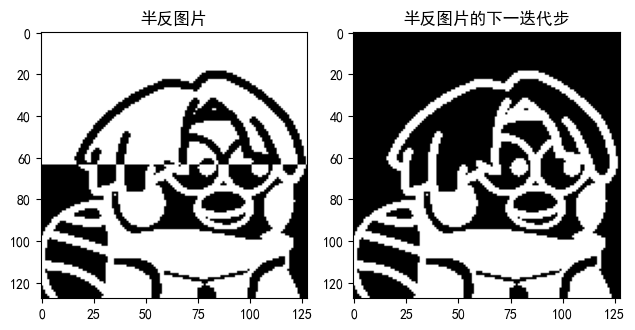

In [27]:
i_,j_=pic_size
destory_imnp=im_np.copy()
for i in range(i_):
    for j in range(j_):
        if (i<i_*0.5):
            destory_imnp[i][j]*=-1
plt.subplot(1, 2, 1)
plt.imshow(destory_imnp, cmap='gray')
plt.title('半反图片')
destory_im_line = destory_imnp.reshape(-1)

pre_line=a.predict(destory_im_line,asyn=True)
pre_im=pre_line.reshape(pic_size)
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 2, 2)
plt.imshow(pre_im, cmap='gray')
plt.title('半反图片的下一迭代步')
# plt.savefig('../fig/repicture_anti2.pdf')
plt.tight_layout()
plt.savefig('../fig/repicture_anti3.pdf', bbox_inches='tight')
plt.show()


## 增加一张图片

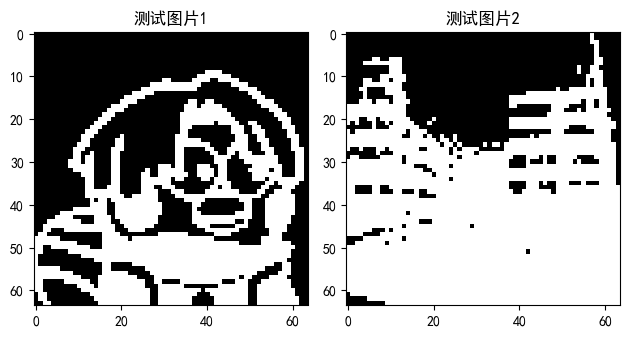

In [28]:
imlist=['1.jpg','2.jpg']
im_np_list=[]
pic_size = 64, 64

for i in imlist:
    im = Image.open(i)
    im=im.convert('L')
    im=im.resize((640,640))
    im.thumbnail(pic_size, Image.Resampling.LANCZOS)
    im_np = np.asarray(im)
    # print(im_np)
    im_np = np.where(im_np<128, 1, -1)
    # print(im_np)
    # plt.imshow(im_np, cmap='gray')
    # plt.show()
    im_np_list.append(im_np)
im_line_list= np.array([i.reshape(-1) for i in im_np_list])

size=im_line_list[0].shape[0]

plt.subplot(1, 2, 1)
plt.imshow(im_line_list[0].reshape(pic_size), cmap='gray')
plt.title('测试图片1')

plt.subplot(1, 2, 2)
plt.imshow(im_line_list[1].reshape(pic_size), cmap='gray')
plt.title('测试图片2')

plt.tight_layout()
plt.savefig('../fig/test_pictures.pdf', bbox_inches='tight')
plt.show()

Start to train weights...
Trian complete.


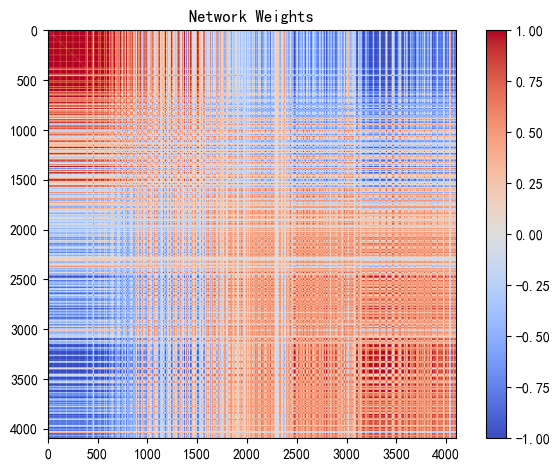

In [29]:
b=HopfieldNetwork(size)
b.train(im_line_list)
b.plot_weights(save='../fig/weights2.pdf')

Start to predict...
Predict Successfully!


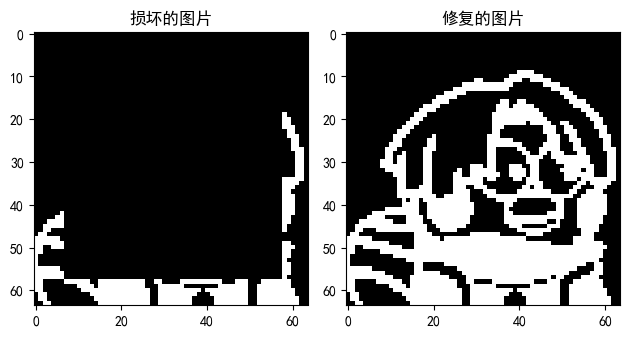

In [30]:
destory_im_line=im_line_list[0].copy()
destory_im=destory_im_line.reshape(pic_size)
i_,j_=pic_size
for i in range(i_):
    for j in range(j_):
        if (i>0.1*i_ and i<0.9*i_ and j>0.1*j_ and j<0.9*j_):
            destory_im[i][j]=-1
destory_im_line=destory_im.reshape(-1)

plt.subplot(1, 2, 1)
plt.imshow(destory_im_line.reshape(pic_size), cmap='gray')

pre_line=b.predict(destory_im_line)
plt.title('损坏的图片')
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 2, 2)
plt.imshow(pre_line.reshape(pic_size), cmap='gray')
plt.title('修复的图片')
plt.tight_layout()
plt.savefig('../fig/re2picture1.pdf', bbox_inches='tight')
plt.show()

Start to predict...
Predict Successfully!


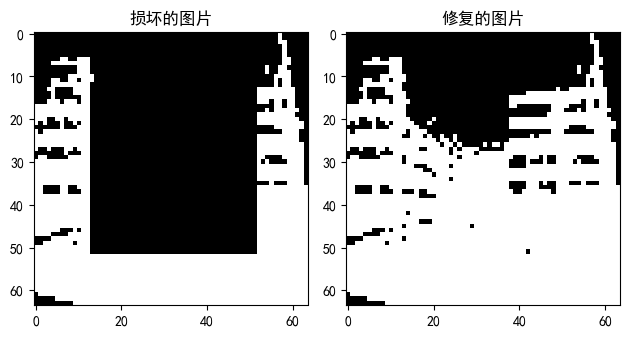

In [31]:
destory_im_line=im_line_list[1].copy()
destory_im=destory_im_line.reshape(pic_size)
i_,j_=pic_size
for i in range(i_):
    for j in range(j_):
        if (i>0.2*i_ and i<0.8*i_ and j>0.2*j_ and j<0.8*j_):
            destory_im[i][j]=-1
destory_im_line=destory_im.reshape(-1)

plt.subplot(1, 2, 1)
plt.imshow(destory_im_line.reshape(pic_size), cmap='gray')
plt.title('损坏的图片')
pre_line=b.predict(destory_im_line)
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 2, 2)
plt.imshow(pre_line.reshape(pic_size), cmap='gray')
plt.title('修复的图片')
plt.tight_layout()
plt.savefig('../fig/re2picture2.pdf', bbox_inches='tight')
plt.show()

Start to predict...
Predict Successfully!


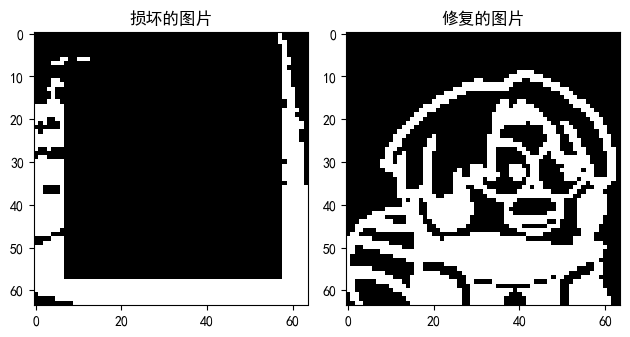

In [32]:
destory_im_line=im_line_list[1].copy()
destory_im=destory_im_line.reshape(pic_size)
i_,j_=pic_size
for i in range(i_):
    for j in range(j_):
        if (i>0.1*i_ and i<0.9*i_ and j>0.1*j_ and j<0.9*j_):
            destory_im[i][j]=-1
destory_im_line=destory_im.reshape(-1)

plt.subplot(1, 2, 1)
plt.imshow(destory_im_line.reshape(pic_size), cmap='gray')

pre_line=b.predict(destory_im_line)
plt.title('损坏的图片')
# np.array_equal(im_np,pre_im_np)
plt.subplot(1, 2, 2)
plt.imshow(pre_line.reshape(pic_size), cmap='gray')
plt.title('修复的图片')
plt.tight_layout()
plt.savefig('../fig/re2picture3.pdf', bbox_inches='tight')
plt.show()